In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import cv2
import os
from tqdm import tqdm
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')

In [2]:
train_dir="/home/geekysethi/Desktop/age-and-gender/traffic_signal/data/train/Final_Training/Images"
# train_dir="/data/train/Final_Training/Images"

img_size=32
LR=1e-3
model_name='trafficsignal-{}-{}.model'.format(LR,'2conv_basic')


In [3]:
def readTrafficSigns(rootpath):
    final_df=pd.DataFrame()

    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = prefix + 'GT-'+ format(c, '05d') + '.csv' # annotations file
        
        gtReader = pd.read_csv(gtFile, delimiter=';',index_col=None,header=0) # csv parser for annotations file
        gtReader.Filename=prefix+gtReader.Filename
#         print(gtReader)
        final_df=final_df.append(gtReader,ignore_index=True)




    print(len(final_df))
    print(final_df.head())
    print(final_df.tail())
    return final_df

In [4]:
final_df=readTrafficSigns(train_dir)

39209
                                            Filename  Width  Height  Roi.X1  \
0  /home/geekysethi/Desktop/age-and-gender/traffi...     29      30       5   
1  /home/geekysethi/Desktop/age-and-gender/traffi...     30      30       5   
2  /home/geekysethi/Desktop/age-and-gender/traffi...     30      30       5   
3  /home/geekysethi/Desktop/age-and-gender/traffi...     31      31       5   
4  /home/geekysethi/Desktop/age-and-gender/traffi...     30      32       5   

   Roi.Y1  Roi.X2  Roi.Y2  ClassId  
0       6      24      25        0  
1       5      25      25        0  
2       5      25      25        0  
3       5      26      26        0  
4       6      25      26        0  
                                                Filename  Width  Height  \
39204  /home/geekysethi/Desktop/age-and-gender/traffi...     52      56   
39205  /home/geekysethi/Desktop/age-and-gender/traffi...     56      58   
39206  /home/geekysethi/Desktop/age-and-gender/traffi...     58      62 

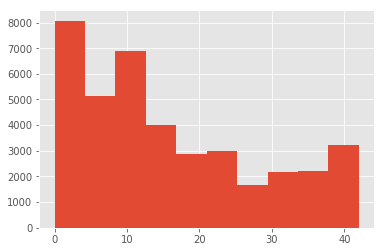

In [5]:
final_df.ClassId.hist()


In [6]:
n_files=len(final_df)
allX = np.zeros((n_files, img_size, img_size, 3), dtype='float64')
ally = final_df.ClassId.values
img_paths=final_df.Filename.values

count=0
for i in tqdm(img_paths):
    img=cv2.imread(i,1)
    img=cv2.resize(img,(img_size,img_size))
    allX[count]=np.array(img)
    count+=1



100%|██████████| 39209/39209 [00:02<00:00, 15060.01it/s]


In [7]:
print(np.shape(allX))
print(ally)

(39209, 32, 32, 3)
[ 0  0  0 ..., 42 42 42]


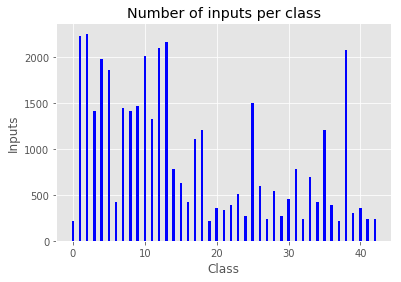

In [8]:
inputs_per_class = np.bincount(ally)
max_inputs = np.max(inputs_per_class)
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.set_ylabel('Inputs')
ax.set_xlabel('Class')
ax.set_title('Number of inputs per class')
ax.bar(range(len(inputs_per_class)), inputs_per_class, 1/3, color='blue', label='Inputs per class')
plt.show()


In [9]:
# len(inputs_per_class)
print(sum(inputs_per_class))
n_classes = max(ally) + 1
n_classes


39209


43

In [10]:
import random
import scipy.ndimage
import glob
angles = [-5, 5, -10, 10, -15, 15, -20, 20]


counter=0

for i in range(len(inputs_per_class)):
    input_ratio = int(max_inputs / inputs_per_class[i])-1
    
    if input_ratio>2:
        new_features=[]
        new_lables=[]
        print(input_ratio,i)
        prefix = train_dir + '/' + format(i, '05d') + '/*.ppm'
        path=np.sort(glob.glob(prefix))
#         print("total images:",len(path))

        for j in path:
            img = cv2.imread(j,1)# this is a PIL image
#         print(np.shape(img))
            img=cv2.resize(img,(img_size,img_size))
#             print(np.shape(img))
        
            for k in range(input_ratio-2):
                counter+=1
                new_features.append(scipy.ndimage.rotate(img, random.choice(angles), reshape=False))
                new_lables.append(i)
#                 print(np.shape(new_features))
#                 print(new_features)
        allX=np.append(allX,new_features,axis=0)
        ally=np.append(ally,new_lables,axis=0)
        print(counter)
        


9 0
1470
4 6
2310
4 16
3150
9 19
4620
5 20
5700
5 21
6690
4 22
7470
3 23
7980
7 24
9330
8 27
10770
3 28
11310
7 29
12660
4 30
13560
8 32
15000
4 34
15840
4 36
16620
9 37
18090
6 39
19290
5 40
20370
8 41
21810
8 42
23250


In [11]:
print(len(allX))
print(len(ally))


62459
62459


In [12]:
# print(np.shape(X))
# print(np.shape(Y))


NameError: name 'X' is not defined

In [13]:
from sklearn.cross_validation import train_test_split
from tflearn.data_utils import shuffle, to_categorical


X, X_test, Y, Y_test = train_test_split(allX, ally, test_size=0.2, random_state=42)

X, Y = shuffle(X, Y) 
Y = to_categorical(Y, n_classes)
Y_test = to_categorical(Y_test, n_classes)


/home/geekysethi/.virtualenvs/cv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
print(np.shape(X))
print(np.shape(Y))


(49967, 32, 32, 3)
(49967, 43)


In [15]:
print(Y[:12])

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  

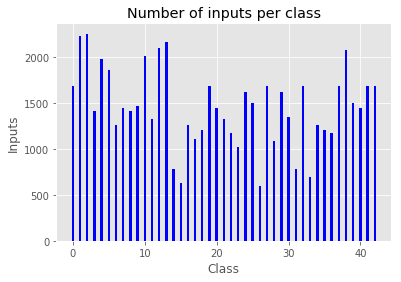

In [16]:
inputs_per_class = np.bincount(ally)
max_inputs = np.max(inputs_per_class)
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.set_ylabel('Inputs')
ax.set_xlabel('Class')
ax.set_title('Number of inputs per class')
ax.bar(range(len(inputs_per_class)), inputs_per_class, 1/3, color='blue', label='Inputs per class')
plt.show()


In [17]:
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Create extra synthetic training data by flipping & rotating images
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)


In [ ]:
###################################
# Define network architecture
###################################
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.metrics import Accuracy

# Input is a 32x32 image with 3 color channels (red, green and blue)
network = input_data(shape=[None, img_size, img_size, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug,name='')


# network = input_data(shape=[None, img_size, img_size, 3],name='input')

# 1: Convolution layer with 32 filters, each 3x3x3
conv_1 = conv_2d(network, 32, 3, activation='relu', name='conv_1')

# 2: Max pooling layer
network = max_pool_2d(conv_1, 2)

# 3: Convolution layer with 64 filters
conv_2 = conv_2d(network, 64, 3, activation='relu', name='conv_2')

# 4: Convolution layer with 64 filters
conv_3 = conv_2d(conv_2, 64, 3, activation='relu', name='conv_3')

# 5: Max pooling layer
network = max_pool_2d(conv_3, 2)

# 6: Fully-connected 512 node layer
network = fully_connected(network, 512, activation='relu')

# 7: Dropout layer to combat overfitting
network = dropout(network, 0.5)

# 8: Fully-connected layer with two outputs
network = fully_connected(network, n_classes, activation='softmax')

# Configure how the network will be trained
acc = Accuracy(name="Accuracy")
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.0005, metric=acc)

# Wrap the network in a model object
model = tflearn.DNN(network,tensorboard_verbose = 3, tensorboard_dir='tmp/tflearn_logs/')

###################################
# Train model for 100 epochs
###################################
model.fit(X, Y, validation_set=(X_test, Y_test), batch_size=500,
      n_epoch=10, run_id=model_name, show_metric=True)

model.save(model_name)
